In [136]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/satellite-image-classification
/kaggle/input/satellite-image-classification/data
/kaggle/input/satellite-image-classification/data/cloudy
/kaggle/input/satellite-image-classification/data/desert
/kaggle/input/satellite-image-classification/data/green_area
/kaggle/input/satellite-image-classification/data/water


In [137]:
!nvidia-smi

Mon Jun 12 05:16:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   1204MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

#### Importing Necessary Modules

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [139]:
from tqdm import tqdm
import torch.nn.parallel as parallel

### Reading Files from Imagefolder 

In [140]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(64),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

In [141]:
dataset = ImageFolder('/kaggle/input/satellite-image-classification/data/', transform=transform)

In [142]:
dataset[0][0].shape

torch.Size([3, 64, 64])

In [143]:
dataset.classes

['cloudy', 'desert', 'green_area', 'water']

In [144]:
len(dataset)

5631

In [145]:
from collections import Counter
value_counts = dict(Counter(dataset.targets))

In [146]:
value_counts = dict(zip(dataset.classes, value_counts.values()))

print(value_counts)

{'cloudy': 1500, 'desert': 1131, 'green_area': 1500, 'water': 1500}


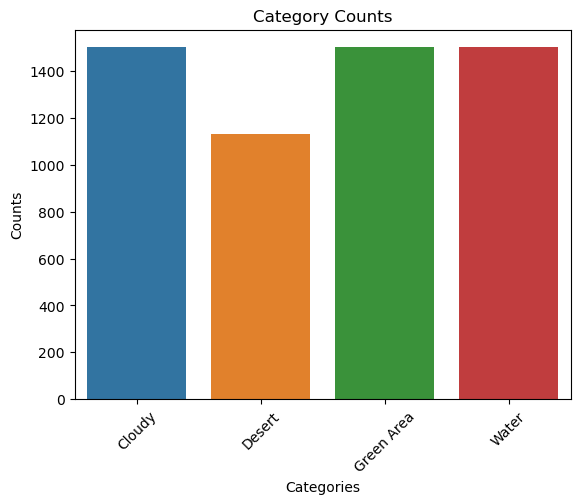

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=list(value_counts.keys()), y= list(value_counts.values()))
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Category Counts')
plt.xticks(range(4),labels = ["Cloudy", "Desert", "Green Area", "Water"], rotation = 45)
plt.show()

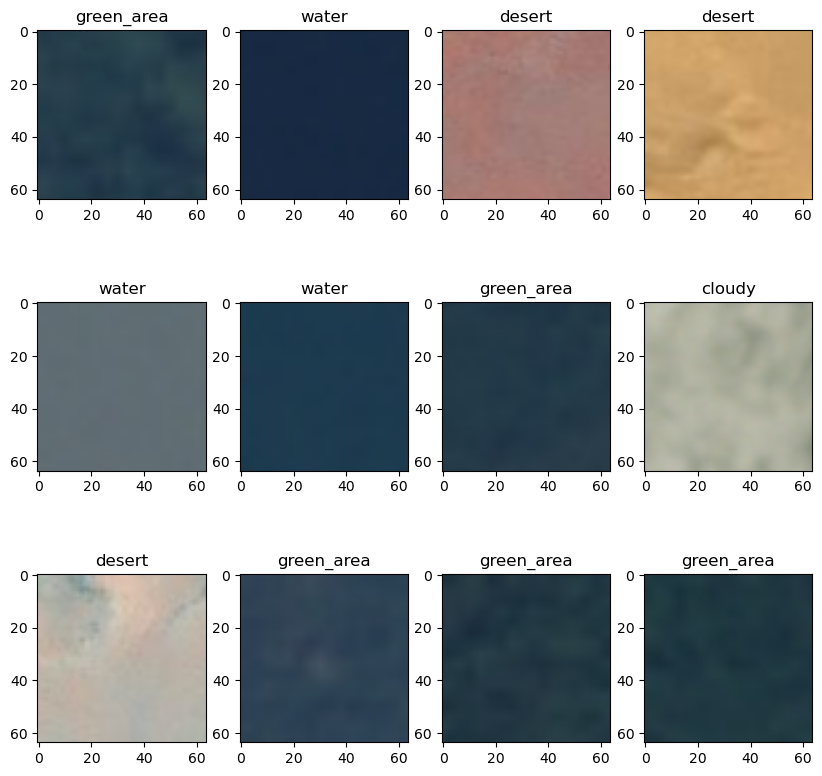

In [148]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns * rows + 1):
    idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[idx]
    class_name = dataset.classes[label]
    fig.add_subplot(rows, columns, i)
    plt.title(class_name)
    plt.imshow(img.permute(1, 2, 0))
plt.show()


In [149]:
test_size = 0.2

num_dataset = len(dataset)
num_test = int(num_dataset * test_size)
num_train = num_dataset - num_test
print('Number of Points in Dataset - {0}'.format(num_dataset))
print('Number of Points in Training Dataset - {0}'.format(num_train))
print('Number of Points in Testing Dataset - {0}'.format(num_test))


Number of Points in Dataset - 5631
Number of Points in Training Dataset - 4505
Number of Points in Testing Dataset - 1126


In [150]:
train_set, test_set = torch.utils.data.random_split(dataset, [num_train, num_test])
train_set[0][0].shape

torch.Size([3, 64, 64])

In [151]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True, num_workers=2)

In [152]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 16 * 16, 64)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Create an instance of the model
model = CNNModel()

# Print the model summary
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


In [153]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = parallel.DataParallel(model)

# Move the model to the available device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Using 2 GPUs!


DataParallel(
  (module): CNNModel(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=16384, out_features=64, bias=True)
    (relu4): ReLU()
    (fc2): Linear(in_features=64, out_features=4, bias=True)
    (softmax): Softmax(dim=1)
  )
)

In [154]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =  0.001)

In [155]:
# Training loop
train_accuracies = []
test_accuracies = []
num_epochs = 25
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train
    
    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test
    
    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")


100%|██████████| 564/564 [00:12<00:00, 44.88it/s]


Epoch 1/25 - Train Loss: 1.3842 - Train Acc: 0.2930 - Test Loss: 1.3810 - Test Acc: 0.2798


100%|██████████| 564/564 [00:11<00:00, 49.74it/s]


Epoch 2/25 - Train Loss: 1.3786 - Train Acc: 0.2630 - Test Loss: 1.3728 - Test Acc: 0.2798


100%|██████████| 564/564 [00:12<00:00, 46.78it/s]


Epoch 3/25 - Train Loss: 1.3673 - Train Acc: 0.2630 - Test Loss: 1.3544 - Test Acc: 0.2798


100%|██████████| 564/564 [00:11<00:00, 49.76it/s]


Epoch 4/25 - Train Loss: 1.3477 - Train Acc: 0.2630 - Test Loss: 1.3309 - Test Acc: 0.2798


100%|██████████| 564/564 [00:11<00:00, 47.26it/s]


Epoch 5/25 - Train Loss: 1.3273 - Train Acc: 0.2948 - Test Loss: 1.3071 - Test Acc: 0.3792


100%|██████████| 564/564 [00:11<00:00, 49.61it/s]


Epoch 6/25 - Train Loss: 1.3004 - Train Acc: 0.4231 - Test Loss: 1.2779 - Test Acc: 0.4671


100%|██████████| 564/564 [00:11<00:00, 49.44it/s]


Epoch 7/25 - Train Loss: 1.2667 - Train Acc: 0.4590 - Test Loss: 1.2397 - Test Acc: 0.4840


100%|██████████| 564/564 [00:11<00:00, 49.01it/s]


Epoch 8/25 - Train Loss: 1.2200 - Train Acc: 0.4828 - Test Loss: 1.1934 - Test Acc: 0.6288


100%|██████████| 564/564 [00:11<00:00, 49.99it/s]


Epoch 9/25 - Train Loss: 1.1726 - Train Acc: 0.5980 - Test Loss: 1.1522 - Test Acc: 0.6217


100%|██████████| 564/564 [00:11<00:00, 47.05it/s]


Epoch 10/25 - Train Loss: 1.1327 - Train Acc: 0.6475 - Test Loss: 1.1133 - Test Acc: 0.6252


100%|██████████| 564/564 [00:11<00:00, 49.39it/s]


Epoch 11/25 - Train Loss: 1.0957 - Train Acc: 0.6863 - Test Loss: 1.0770 - Test Acc: 0.7238


100%|██████████| 564/564 [00:11<00:00, 47.21it/s]


Epoch 12/25 - Train Loss: 1.0635 - Train Acc: 0.7110 - Test Loss: 1.0415 - Test Acc: 0.7185


100%|██████████| 564/564 [00:11<00:00, 49.96it/s]


Epoch 13/25 - Train Loss: 1.0382 - Train Acc: 0.7205 - Test Loss: 1.0456 - Test Acc: 0.7114


100%|██████████| 564/564 [00:12<00:00, 46.29it/s]


Epoch 14/25 - Train Loss: 1.0234 - Train Acc: 0.7265 - Test Loss: 1.0645 - Test Acc: 0.6865


100%|██████████| 564/564 [00:11<00:00, 48.90it/s]


Epoch 15/25 - Train Loss: 1.0146 - Train Acc: 0.7343 - Test Loss: 1.1368 - Test Acc: 0.5799


100%|██████████| 564/564 [00:11<00:00, 49.26it/s]


Epoch 16/25 - Train Loss: 1.0093 - Train Acc: 0.7303 - Test Loss: 1.1439 - Test Acc: 0.5968


100%|██████████| 564/564 [00:11<00:00, 49.48it/s]


Epoch 17/25 - Train Loss: 1.0077 - Train Acc: 0.7274 - Test Loss: 1.0233 - Test Acc: 0.7300


100%|██████████| 564/564 [00:11<00:00, 49.51it/s]


Epoch 18/25 - Train Loss: 0.9996 - Train Acc: 0.7390 - Test Loss: 1.0067 - Test Acc: 0.7282


100%|██████████| 564/564 [00:12<00:00, 46.47it/s]


Epoch 19/25 - Train Loss: 1.0004 - Train Acc: 0.7381 - Test Loss: 0.9875 - Test Acc: 0.7584


100%|██████████| 564/564 [00:11<00:00, 49.36it/s]


Epoch 20/25 - Train Loss: 0.9990 - Train Acc: 0.7365 - Test Loss: 1.0193 - Test Acc: 0.7158


100%|██████████| 564/564 [00:12<00:00, 46.64it/s]


Epoch 21/25 - Train Loss: 0.9991 - Train Acc: 0.7358 - Test Loss: 0.9997 - Test Acc: 0.7265


100%|██████████| 564/564 [00:11<00:00, 49.81it/s]


Epoch 22/25 - Train Loss: 0.9974 - Train Acc: 0.7358 - Test Loss: 0.9843 - Test Acc: 0.7602


100%|██████████| 564/564 [00:11<00:00, 47.10it/s]


Epoch 23/25 - Train Loss: 0.9966 - Train Acc: 0.7385 - Test Loss: 0.9851 - Test Acc: 0.7558


100%|██████████| 564/564 [00:11<00:00, 49.90it/s]


Epoch 24/25 - Train Loss: 0.9947 - Train Acc: 0.7412 - Test Loss: 0.9833 - Test Acc: 0.7558


100%|██████████| 564/564 [00:12<00:00, 46.90it/s]


Epoch 25/25 - Train Loss: 0.9952 - Train Acc: 0.7396 - Test Loss: 0.9868 - Test Acc: 0.7425


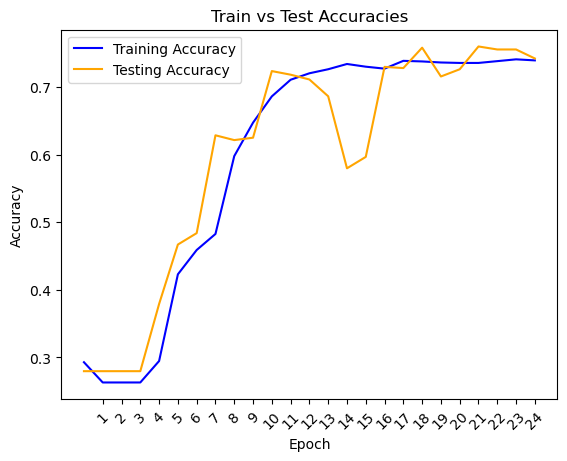

In [156]:
sns.lineplot(x = range(25), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(25), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,25), rotation = 45)
plt.yticks(label = range(1,100,10))
plt.legend()
plt.show()

In [157]:
from sklearn.metrics import confusion_matrix


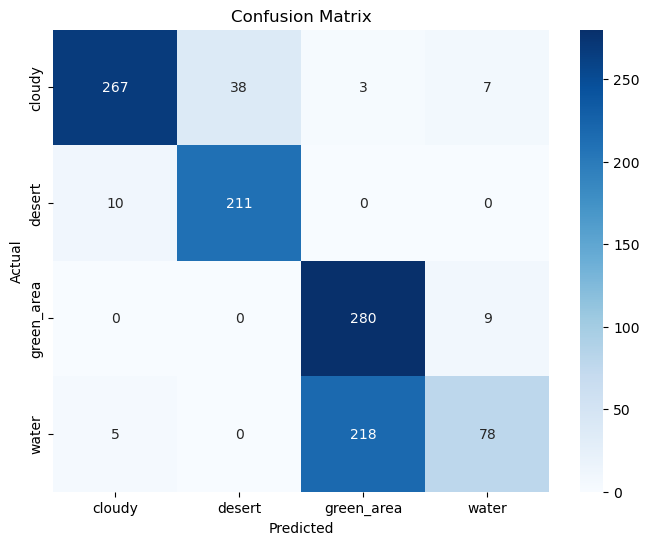

In [160]:
cm = confusion_matrix(all_targets, all_predictions)
labels = dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
